In [1]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [28]:
def read_video(path:str) -> list:
    video_cap = cv2.VideoCapture(path)

    if not video_cap.isOpened():
        raise ValueError("Could not open video file")

    frames = list()
    while True:
        ret, frame = video_cap.read()
        if not ret:
            break 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    return np.array(frames)

def mean_frame(video_frames, n_frames=0.3):
    frame_idx = np.random.choice(np.arange(video_frames.shape[0]), size=int(len(video_frames) * n_frames / 2))
    frames_subsample = video_frames[frame_idx]
    rotated_frames = np.rot90(frames_subsample, k=2, axes=(1, 2)) 
    mean_frame = np.mean(
        np.concatenate((frames_subsample, rotated_frames), axis=0),
        axis=0).astype(np.uint8)
    return mean_frame

#def mean_frame(video_frames, n_frames=0.3):
#    mean_frame = np.mean(
#        random.sample(video_frames, int(len(video) * 0.4)), 
#        axis=0).astype(np.uint8)
#    return mean_frame

def osd_edges(frame):
    edges = cv2.Canny(frame, 20, 150, apertureSize = 3)
    # Create a kernel for dilation
    kernel = np.ones((3, 3), np.uint8)

    # Perform morphological dilation to fill the edges
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    # Find contours of the detected edges
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank image of the same size as the original
    filled_image = np.zeros_like(edges)

    # Fill the detected contours
    for contour in contours:
        cv2.fillPoly(filled_image, [contour], color=(255))
    
    filled_image = crop_osd(filled_image)
    return filled_image

def crop_osd(edges, margin_percentage=0.05):
    height, width = edges.shape

    x_center = height  // 2
    y_center = width // 2

    x_margin = int(height * margin_percentage)
    y_margin = int(width * margin_percentage)

    margin = max(x_margin, y_margin)

    center_edges = edges[
        x_center - margin: x_center + margin, 
        y_center - margin: y_center + margin]
    
    rotated_edges = np.rot90(center_edges)

    edges[
        x_center - margin: x_center + margin, 
        y_center - margin: y_center + margin] =  center_edges | rotated_edges
    
    return edges


def inpaint_OSD(frame, mask):
    # Apply inpainting to remove OSD
    inpaint_result = cv2.inpaint(frame, mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)
    
    return inpaint_result

def pipeline(video):
    m_frame = mean_frame(video)
    edges = osd_edges(m_frame)
    plt.imshow(edges)
    
    for idx, frame in enumerate(video):
        inp = inpaint_OSD(frame, edges)
        plt.imshow(inp)
        plt.title(f'Frame: {idx}')
        clear_output(True)
        plt.show()


In [32]:
video_path = '../assets/test_video.mp4'
video = read_video(video_path)

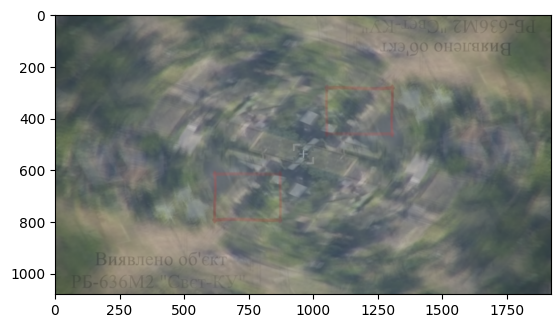

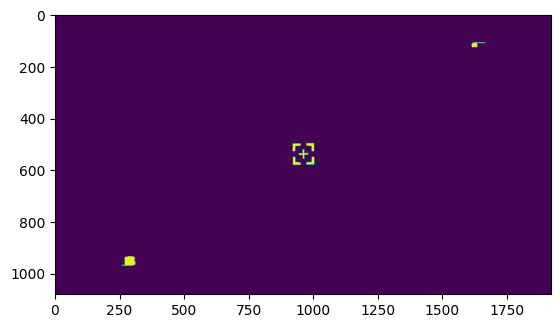

In [33]:
m_frame = mean_frame(video[:300])
plt.imshow(m_frame)
plt.show() 

edges = osd_edges(m_frame)
plt.imshow(edges)

In [34]:
pipeline(video)

KeyboardInterrupt: 

In [92]:
video_path = '../assets/test_video3.mp4'
video = read_video(video_path)

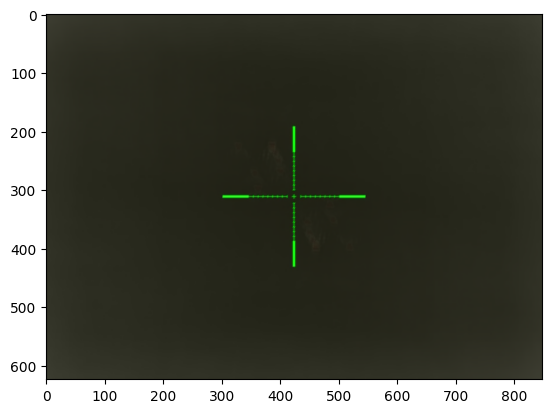

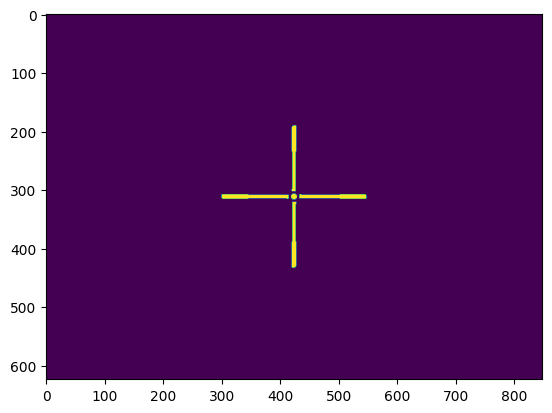

In [93]:
m_frame = mean_frame(video)
plt.imshow(m_frame)
plt.show()

edges = osd_edges(m_frame)
plt.imshow(edges)

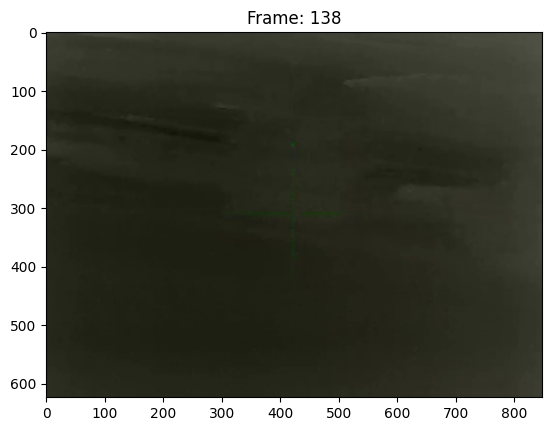

In [94]:
pipeline(video)